<a href="https://colab.research.google.com/github/bongkyunSON/Deep_Leaning/blob/main/Prophet_case2_230102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid Spread Forecasting Using Fb Prophet

In [ ]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/prophet_강의/data/covid19_data.csv')

In [ ]:
df.head()

,Report_Date,Afghanistan_cases,Afghanistan_deaths,Afghanistan_recovered,Albania_cases,Albania_deaths,Albania_recovered,Algeria_cases,Algeria_deaths,Algeria_recovered,...,Winter Olympics 2022_recovered,Yemen_cases,Yemen_deaths,Yemen_recovered,Zambia_cases,Zambia_deaths,Zambia_recovered,Zimbabwe_cases,Zimbabwe_deaths,Zimbabwe_recovered
0,2022-04-06,177974,7671,0,274055,3492,0,265705,6874,0,...,0,11812,2144,0,317358,3967,0,246803,5453,0
1,2022-04-07,177974,7671,0,274108,3492,0,265707,6874,0,...,0,11812,2145,0,317483,3967,0,246870,5455,0
2,2022-04-08,177974,7671,0,274136,3492,0,265714,6874,0,...,0,11812,2146,0,317483,3967,0,246925,5457,0
3,2022-04-09,177974,7671,0,274191,3492,0,265720,6874,0,...,0,11813,2147,0,317483,3967,0,246925,5457,0
4,2022-04-10,177974,7671,0,274219,3493,0,265724,6874,0,...,0,11813,2147,0,317483,3967,0,246958,5457,0


In [ ]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [ ]:
# now check sopme basic info of our dataset
descriptive_info(df)

Features: 853   Entries: 30



Printing descriptive statistics...

        Afghanistan_cases  Afghanistan_deaths  Afghanistan_recovered  \
count          30.000000           30.000000                   30.0   
mean       178521.833333         7678.800000                    0.0   
std           331.756567            4.482918                    0.0   
min        177974.000000         7671.000000                    0.0   
25%        178309.250000         7676.000000                    0.0   
50%        178592.500000         7680.000000                    0.0   
75%        178839.750000         7683.000000                    0.0   
max        178905.000000         7684.000000                    0.0   

       Albania_cases  Albania_deaths  Albania_recovered  Algeria_cases  \
count      30.000000       30.000000               30.0      30.000000   
mean   274656.966667     3495.066667                0.0  265751.600000   
std       380.623217        1.507071                0.0      25.296313

In [ ]:
spike_cols = [col for col in df.columns if 'US' in col]

In [ ]:
print(spike_cols)

['USA_cases', 'USA_deaths', 'USA_recovered']


The analysis will be similar for all countries. Here we'll investigate the US data only. If interested, play around with other countries similarly.

In [ ]:
# let's EXTRACT COLUMSN WITH USA DATA
df_us = df[['Report_Date', 'USA_cases', 'USA_deaths', 'USA_recovered']]

In [ ]:
df_us.head()

,Report_Date,USA_cases,USA_deaths,USA_recovered
0,2022-04-06,80255129,984260,0
1,2022-04-07,80302516,984953,0
2,2022-04-08,80390106,985593,0
3,2022-04-09,80402760,985732,0
4,2022-04-10,80412219,985757,0


In [ ]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [ ]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df_us, ds = 'Report_Date', y = 'USA_cases') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

           ds         y
0  2022-04-06  80255129
1  2022-04-07  80302516
2  2022-04-08  80390106
3  2022-04-09  80402760
4  2022-04-10  80412219

The length of your series is:  30


In [ ]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

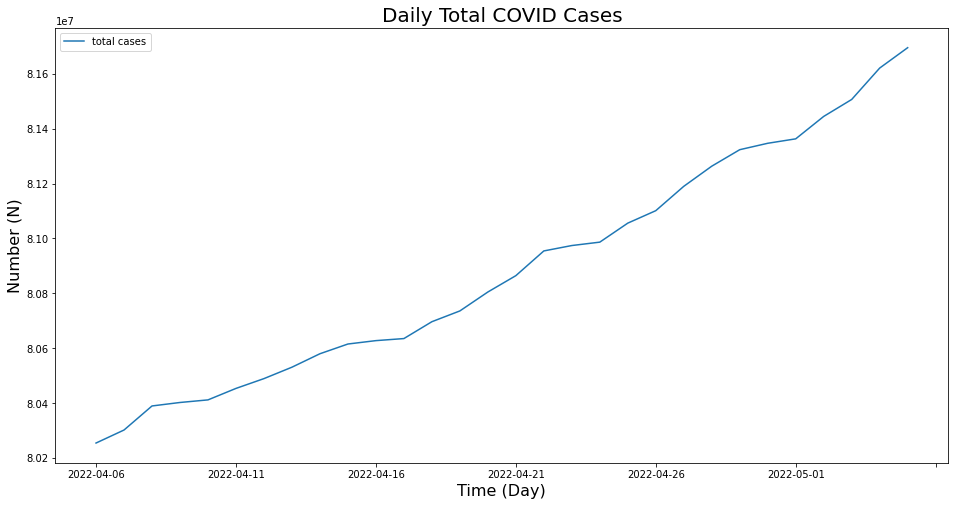

In [ ]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "total cases"
Figsize = (16,8)
Title = "Daily Total COVID Cases"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Number (N)'
_fig_plot(df2, X, Y)

In [ ]:
# define training dataset
train = df2.copy()

In [ ]:
# Let's fit the model

prophet = Prophet(growth="linear",
            daily_seasonality= 'auto',
            weekly_seasonality= 'auto',
            yearly_seasonality= 'auto',
            changepoint_prior_scale=0.01)

prophet.fit(train)
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5iossgjm/whc571jz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5iossgjm/b9tnyejg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60042', 'data', 'file=/tmp/tmp5iossgjm/whc571jz.json', 'init=/tmp/tmp5iossgjm/b9tnyejg.json', 'output', 'file=/tmp/tmp5iossgjm/prophet_modelty34kh1w/prophet_model-20230102102302.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Printing outputs from Prophet prediction...
           ds          yhat    yhat_lower    yhat_upper
0 2022-04-06  8.025516e+07  8.025516e+07  8.025516e+07
1 2022-04-07  8.030255e+07  8.030255e+07  8.030255e+07
2 2022-04-08  8.039014e+07  8.039014e+07  8.039014e+07
3 2022-04-09  8.040279e+07  8.040279e+07  8.040279e+07
4 2022-04-10  8.041225e+07  8.041225e+07  8.041225e+07


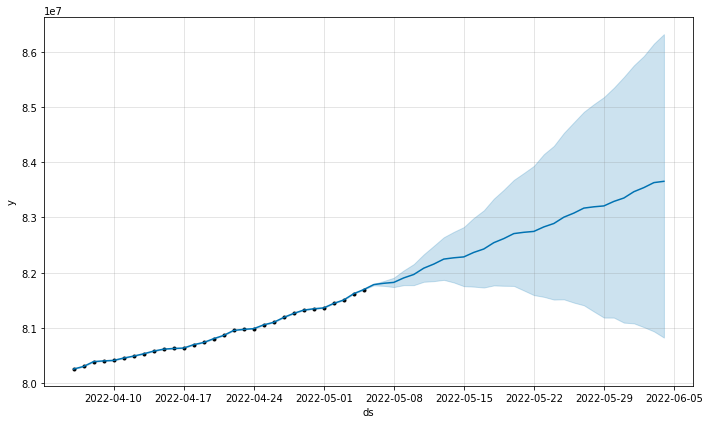

In [ ]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [ ]:
# Use the plot_plotly function to visualize prediction as seperate window size
plot_plotly(prophet, forecast)

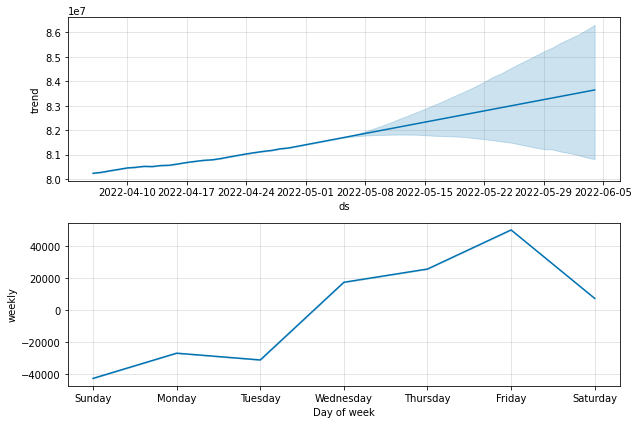

In [ ]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [ ]:
len(train)

30

In [ ]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='20 days', period='4 days', horizon = '2 days')

INFO:prophet:Making 2 forecasts with cutoffs between 2022-04-29 00:00:00 and 2022-05-03 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5iossgjm/15sx37j0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5iossgjm/k1k7o68p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76430', 'data', 'file=/tmp/tmp5iossgjm/15sx37j0.json', 'init=/tmp/tmp5iossgjm/k1k7o68p.json', 'output', 'file=/tmp/tmp5iossgjm/prophet_model0opgaunn/prophet_model-20230102102309.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:23:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5iossgjm/wpyfasyt.json
DEBUG:cmdstanpy:input tempfil

In [ ]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
1,2 days,5.692710e+08,23859.401547,18749.856367,0.000230,0.000230,0.000230,0.5
0,1 days,6.681047e+08,25847.722233,24541.708401,0.000301,0.000301,0.000301,0.5
